# Telco Customer Churn

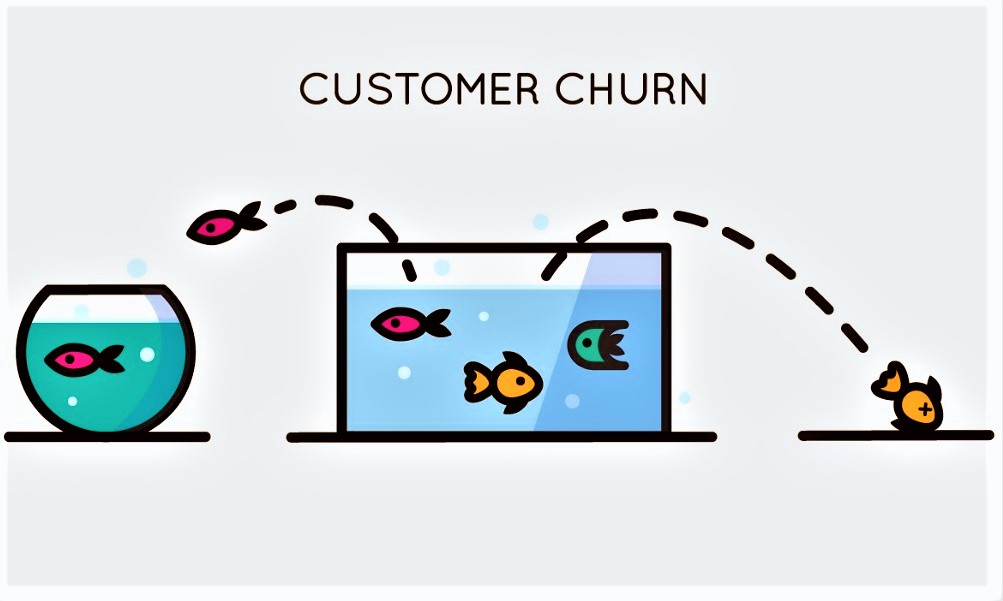

# 1. Import libraries & the Dataset


In [1]:
#! pip install -U imbalanced-learn
#! pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


C:\Users\DEKI_\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Observation, i changed the file type to a xlsx file insted of csv file,
# because i got some problem when loaded the file as a csv file.
# I copy the dataframe becuase I use two diffrent codes when I do some datapreproccessing
df = pd.read_excel('nbi_data_set.xlsx')

# 2. EDA - Exploratory Data analysis

- First i would like to look at the whole dataset, try to understand the data and see if there are any columns we can get rid of.
- The second thing i would like to look at how many Churn there is and see if there are any correlation with monthly charges? 
- The third thing i would like to look at is...


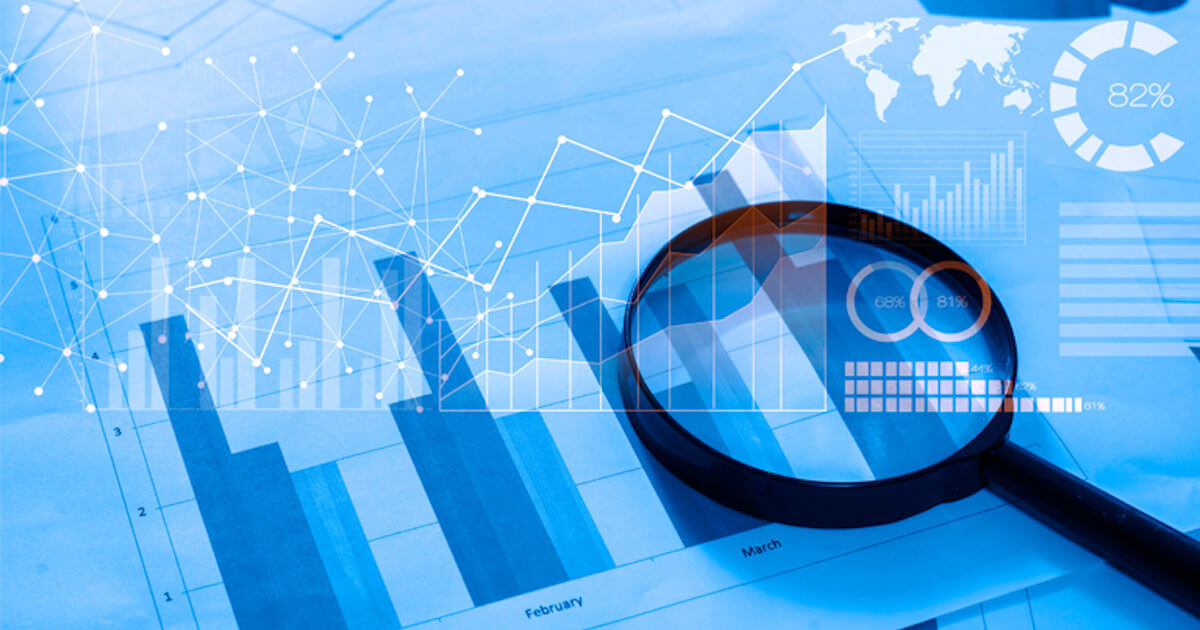

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
3,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
4,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5374 non-null   object 
 1   gender            5374 non-null   object 
 2   SeniorCitizen     5374 non-null   int64  
 3   Partner           5374 non-null   object 
 4   Dependents        5374 non-null   object 
 5   tenure            5374 non-null   int64  
 6   PhoneService      5374 non-null   object 
 7   MultipleLines     5374 non-null   object 
 8   InternetService   5374 non-null   object 
 9   OnlineSecurity    5374 non-null   object 
 10  OnlineBackup      5374 non-null   object 
 11  DeviceProtection  5374 non-null   object 
 12  TechSupport       5374 non-null   object 
 13  StreamingTV       5374 non-null   object 
 14  StreamingMovies   5374 non-null   object 
 15  Contract          5374 non-null   object 
 16  PaperlessBilling  5374 non-null   object 


In [5]:
df.Churn.value_counts()

No     5174
Yes     200
Name: Churn, dtype: int64

<AxesSubplot:ylabel='Churn'>

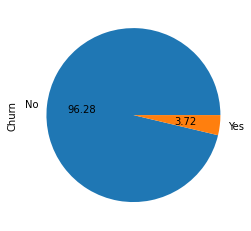

In [6]:
df.Churn.value_counts().plot.pie(autopct='%.2f')

In [7]:
df.Contract.value_counts()

Month-to-month    2393
Two year          1654
One year          1327
Name: Contract, dtype: int64

In [8]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# Checking if null data has an impact on Churn
nan_in_col  = df[df['TotalCharges'].isnull()]
print(nan_in_col['Churn'])

365     No
569     No
699     No
798     No
987     No
2462    No
2818    No
3235    No
3850    No
4903    No
4971    No
Name: Churn, dtype: object


Text(0.5, 1.03, 'Churn within every features')

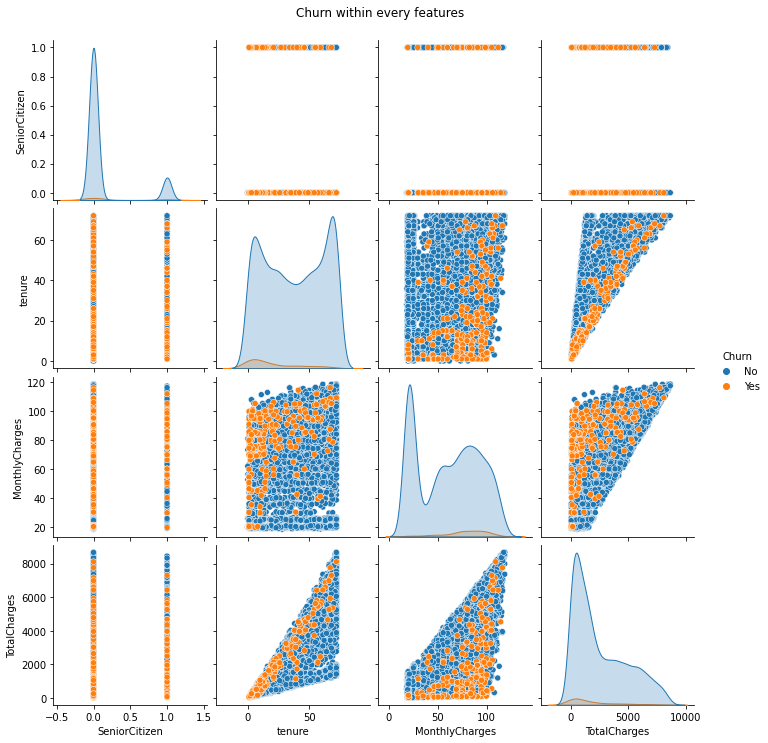

In [11]:
sns.pairplot(df, hue="Churn").fig.suptitle("Churn within every features", y=1.03)

### Information about the dataset:

- The dataset has 5374 rows and 21 columns. 
- Most of the datatypes are objects which must be convertet to a number datatype. 
We need to convert the values to numbers so our ML can read it. I will explain and handle this later on. 
- Total Churn on the dataset are 200 of 5374. 
- We don't not need CustomerID. So this will be deleted.
- We have 11 null values in TotalCharges column. Is not a large number of missing values compared with the dataset and has no Churn values which will not impact our results. I will delete these customer from the dataset.

https://dfrieds.com/data-analysis/value-counts-python-pandas.html

https://stackoverflow.com/questions/26266362/how-do-i-count-the-nan-values-in-a-column-in-pandas-dataframe

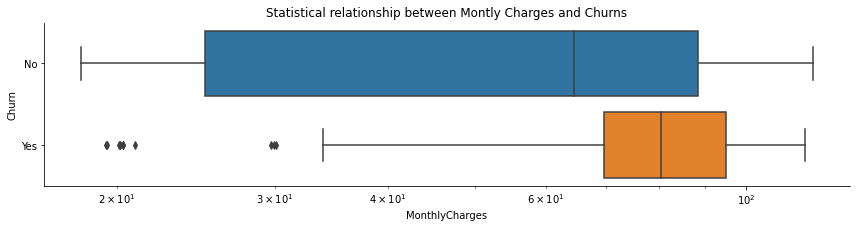

In [13]:
# https://seaborn.pydata.org/tutorial/categorical.html#showing-multiple-relationships-with-facets
g = sns.catplot(x="MonthlyCharges", y="Churn", 
                kind="box", orient="h", height=3, aspect=4,
                data=df)
print(g.set(xscale="log").set(title="Statistical relationship between Montly Charges and Churns"))

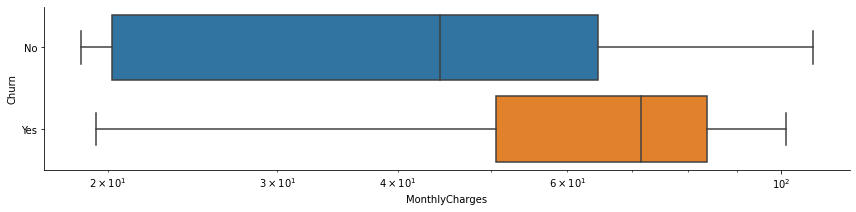

In [12]:
df3 = df.loc[(df.tenure < 5)]
g = sns.catplot(x="MonthlyCharges", y="Churn",
                kind="box", orient="h", height=3, aspect=4,
                data=df3)

g.set(xscale="log")

We can see that customers who have a higher monthly fees, the first 5 months are more likley to be a Churn. Customer who has pays around 45 dollars/month are more likley to stay as customer at the company.

In [13]:
df3.Churn.value_counts()

No     558
Yes     66
Name: Churn, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5374 non-null   object 
 1   gender            5374 non-null   object 
 2   SeniorCitizen     5374 non-null   int64  
 3   Partner           5374 non-null   object 
 4   Dependents        5374 non-null   object 
 5   tenure            5374 non-null   int64  
 6   PhoneService      5374 non-null   object 
 7   MultipleLines     5374 non-null   object 
 8   InternetService   5374 non-null   object 
 9   OnlineSecurity    5374 non-null   object 
 10  OnlineBackup      5374 non-null   object 
 11  DeviceProtection  5374 non-null   object 
 12  TechSupport       5374 non-null   object 
 13  StreamingTV       5374 non-null   object 
 14  StreamingMovies   5374 non-null   object 
 15  Contract          5374 non-null   object 
 16  PaperlessBilling  5374 non-null   object 


# 3. Datapreproccessing 

- The first thing i will do is delete customerID column because it will not impact our ML models. __(1)__
- The Second thing i would do is to drop all NaN values __(2)__
- The third thing i would like to do create a function that would return all columns which is not numerical. This function would give me a better review on which columns i need to convert to numerical values. __(3)__
- The fourth thing i would do is convert object values to numerical values. __(4)__
- The last thing i would do when preprocessing my Data is to scale columns where needed. __(5)__

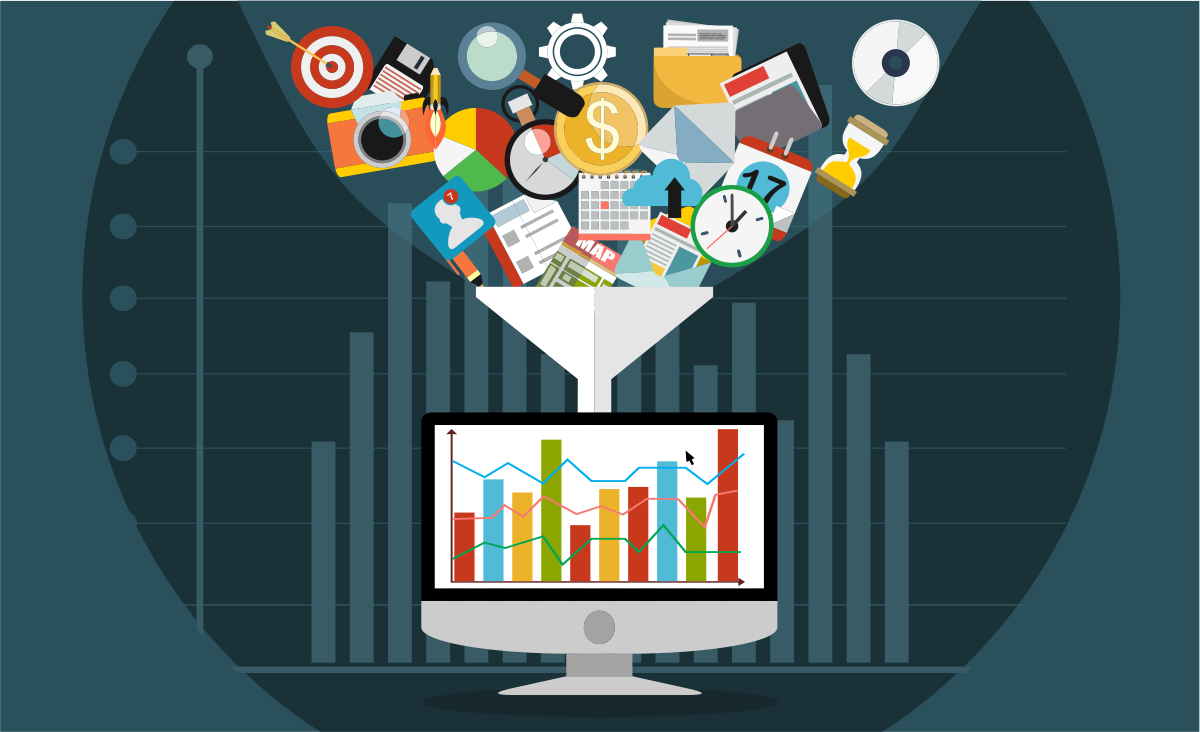

## 1. Deleting customerID column

In [15]:
# Deleting CustomerID
df.drop('customerID',axis='columns',inplace=True)

## 2. Drop all NaN - values

In [16]:
# Deleting null values
df.dropna(inplace=True)

## 3. Creating a function which would return all unique values where columns is not numerical

Iterate over all column names of Dataframe and all the unique values in every column.

Source: https://thispointer.com/count-unique-values-in-all-columns-of-pandas-dataframe/

In [17]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [18]:
def unique_col_values(df):
    for col in df.columns:
        unique_value = df[col].unique()
        if df[col].dtype == 'object':
            print(col, unique_value)

In [19]:
print_unique_col_values(df)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'No internet service' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [20]:
unique_col_values(df)

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'No internet service' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


After Iterating all unique values in every columns where columns == objects, I see same type of cathegorical answer in several columns. The same cathegorical answer is:

- No --> No internet service
- No --> No phone service

By replacing 'No internet service' & 'No phone service' with 'No' will give me more clean data.



Source: https://datatofish.com/replace-values-pandas-dataframe/

In [21]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service','No', inplace=True)

In [22]:
unique_col_values(df)

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


## 4. Change columns from objects to numerical - LabelEncoding vs OneHotEncoder
Next up is Label coding. The Dataset has many columns where there are only two unique values. First up we will change all the columns where the unique values are 'Yes' or 'No' to 1 or 0. Reason why we are doing this is because the ML model can only read numbers not strings. 

After we handle all columns where unique values are 'Yes' or 'No', we will handle Female or Male. Female will be replaced by 0 and Male by 1. Label coding two labels to 1 or 0 can also be called coding dummy variables. 

Why using labelcoding on gender? 
- LE is used when the categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
- If a column only got 2 features, it's okey to use labelencoder. By using labelencoder on a column with only two feature, we counteract multicollinarity. 

Source: https://www.geeksforgeeks.org/replace-the-column-contains-the-values-yes-and-no-with-true-and-false-in-python-pandas/

https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

https://vitalflux.com/when-use-labelencoder-python-example/

https://www.youtube.com/watch?v=dkNkmiPzO4Q&ab_channel=MirkoSavic



In [23]:
# By using LabelEncoder() all columns i the list will transform to dummy variables. 
# This is similar to what we did before with replace. Only diffrence its easier to use Le.
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for column in binary_columns:
    df[column] = le.fit_transform(df[column])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
3,1,0,0,1,22,1,1,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),89.10,1949.40,0
4,0,0,0,0,10,0,0,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,29.75,301.90,0


In [24]:
"""Dummy_variable_col = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity','OnlineBackup',
                     'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies','PaperlessBilling', 'Churn']

for i in Dummy_variable_col:
    df[i].replace({'Yes':1, 'No':0}, inplace=True)"""

"Dummy_variable_col = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity','OnlineBackup',\n                     'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies','PaperlessBilling', 'Churn']\n\nfor i in Dummy_variable_col:\n    df[i].replace({'Yes':1, 'No':0}, inplace=True)"

In [25]:
for i in df.columns:
    print(i, df[i].unique())

gender [0 1]
SeniorCitizen [0 1]
Partner [1 0]
Dependents [0 1]
tenure [ 1 34 45 22 10 62 13 16 58 25 69 52 71 21 12 49 30 72  2 27 46 70 17 63
 43 60 66 47 18  3 31 50 64 56  8 11 42  9 35 48 29 65 38  5 32 36 41  6
  7  4 33 67 23 57 61 15 14 53 20 40 59 24 44 54 51 19 68 28 37 55 26 39]
PhoneService [0 1]
MultipleLines [0 1]
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity [0 1]
OnlineBackup [1 0]
DeviceProtection [0 1]
TechSupport [0 1]
StreamingTV [0 1]
StreamingMovies [0 1]
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling [1 0]
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 42.3  ... 97.35 42.35 41.05]
TotalCharges [  29.85 1889.5  1840.75 ... 3959.35 2636.05  247.25]
Churn [0 1]


In [26]:
"""df.gender.replace({'Female':0, 'Male':1},inplace=True)"""

"df.gender.replace({'Female':0, 'Male':1},inplace=True)"

In [27]:
"""df.head()"""

'df.head()'

In [28]:
unique_col_values(df)

InternetService ['DSL' 'Fiber optic' 'No']
Contract ['Month-to-month' 'One year' 'Two year']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### OneHotEncoder, two diffrent approach. 

- One way is to use sklearn built-in function OneHotEncode to change numerical non-numerical columns to numerical columns. This will automaticly transform the column to seperate dummy columns. 

One-Hot Encoding is another popular technique for treating categorical variables. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a new feature

More information about OneHotEncoder: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

Source: https://www.udemy.com/course/machinelearning/learn/lecture/19039248#questions


In [29]:
"""from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#df.to_numpy()
# transformers[()] -->
# encoder: what transformer we want to use 
# OnHotEncoder(): call the class
# [0]: which column we want to use transformer on
# reminder = 'passtrough' :  uses to keep the column we dont use tranformers on. 

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [7])], remainder= 'passthrough')
X = ct.fit_transform(df)
print(X)
"""

"from sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\n#df.to_numpy()\n# transformers[()] -->\n# encoder: what transformer we want to use \n# OnHotEncoder(): call the class\n# [0]: which column we want to use transformer on\n# reminder = 'passtrough' :  uses to keep the column we dont use tranformers on. \n\nct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [7])], remainder= 'passthrough')\nX = ct.fit_transform(df)\nprint(X)\n"

### By using pd.dummies instead of OneHotEncoder our data will still be a dataframe and keep our column names. 

In [30]:
df = pd.get_dummies(data=df,columns=['InternetService', 'Contract','PaymentMethod'])

# Changing position so our target/Y (Churn) is the last column in dataframe. 
# https://sparkbyexamples.com/pandas/pandas-change-position-of-a-column/
df = df[[c for c in df if c not in ['Churn']] 
       + ['Churn']]

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,34,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,45,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,22,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0
4,0,0,0,0,10,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [31]:
df.dtypes

gender                                       int32
SeniorCitizen                                int64
Partner                                      int32
Dependents                                   int32
tenure                                       int64
PhoneService                                 int32
MultipleLines                                int32
OnlineSecurity                               int32
OnlineBackup                                 int32
DeviceProtection                             int32
TechSupport                                  int32
StreamingTV                                  int32
StreamingMovies                              int32
PaperlessBilling                             int32
MonthlyCharges                             float64
TotalCharges                               float64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
Contract_Month-to-month        

## Splitting the dataset into the Training set and Test set 

Why splitting the dataset into traing and test set? 
- Separating data into training and testing sets is an important part of evaluating data mining models. Typically, when you separate a data set into a training set and testing set, most of the data is used for training, and a smaller portion of the data is used for testing. By splitting data your model havn't seen the test data yet and our ML model will not get dataleakage. So the main reason why splitting the data is not to overfit our model.

- I will split the data 67/33, meaning the data will be split 67% training data and 33% will be our test data.

In [32]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.33, random_state=1)

### Scaling values in columns where needed

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

Distance algorithms like KNN, K-means, and SVM are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity.

Example: If an algorithm is not using the feature scaling method then it can consider the value 3000 meters to be greater than 5 km but that’s actually not true and in this case, the algorithm will give wrong predictions. So, we use Feature Scaling to bring all values to the same magnitudes and thus, tackle this issue.

Two main methods:
- Standardisation: Will work all the time (recomended), right image in the picture, will give you a value between -3 & +3
- Normalisation: Uses when you got a normal distribution and will give you a value 0-1, left image in the picture


We will use Normalisation all MachineLearning models, the scaling method is called MinMaxScaler(). Why use normalisation (or scaling) is  one of  the main parts of ANN learning process. If you do not normalize your inputs between (0,1) or (-1,1) you could not equally distribute importance of each input,  thus naturally  large values become dominant according to less values during ANN training.


Meanwhile some researches says its not necessary to use scaling for ANN. Look at links bellow. I will try both, scaling and no scaling as a good practice just to see the diffrence of the results. 

https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
https://www.udemy.com/course/machinelearning/learn/lecture/19310398#questions
https://www.researchgate.net/post/Why_normalization_is_necessary_in_ANN
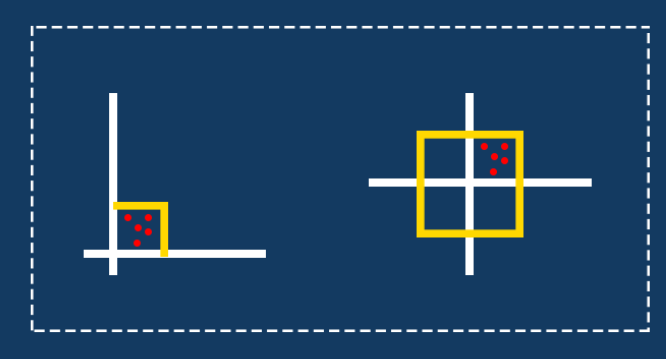

In [34]:
# Creating a function for scaling with MinMaxScaler
def MinMaxSc(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_MinMax_sc = X_train.copy()
    X_train_MinMax_sc = scaler.fit_transform(X_train)
    X_test_MinMax_sc = scaler.transform(X_test)
    return X_train_MinMax_sc, X_test_MinMax_sc

In [35]:
Xtrain_Sc, Xtest_Sc = MinMaxSc(X_train, X_test)

In [36]:
print(pd.DataFrame(Xtrain_Sc[:,4]), pd.DataFrame(Xtest_Sc[:,4]))

             0
0     0.000000
1     0.971831
2     0.535211
3     0.704225
4     0.661972
...        ...
3588  0.647887
3589  0.436620
3590  0.704225
3591  0.704225
3592  0.154930

[3593 rows x 1 columns]              0
0     0.084507
1     0.352113
2     0.774648
3     0.507042
4     0.000000
...        ...
1765  0.690141
1766  0.577465
1767  0.154930
1768  0.816901
1769  0.000000

[1770 rows x 1 columns]


# Resampling our dataset
<blockquote>
“Sampling is a method that allows us to get information about the population based on the statistics from a subset of the population (sample), without having to investigate every individual”
</blockquote>

In other words, when the dataset is imbalanced you can create more data outer thin air, no just kidding. You can create data or remove sampled data randomly by using diffrent methods. I will sample our data in 3 ways: 
- Smote upsampling method
- TomekLinks undersampling method
- SmoteTomek Up-/Undersampling method


For more detail, read links bellow:

__Smote:__ https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/


__TomekLinks:__ https://www.analyticsvidhya.com/blog/2022/05/handling-imbalanced-data-with-imbalance-learn-in-python/


__SmoteTomek:__ https://towardsdatascience.com/stop-using-smote-to-handle-all-your-imbalanced-data-34403399d3be

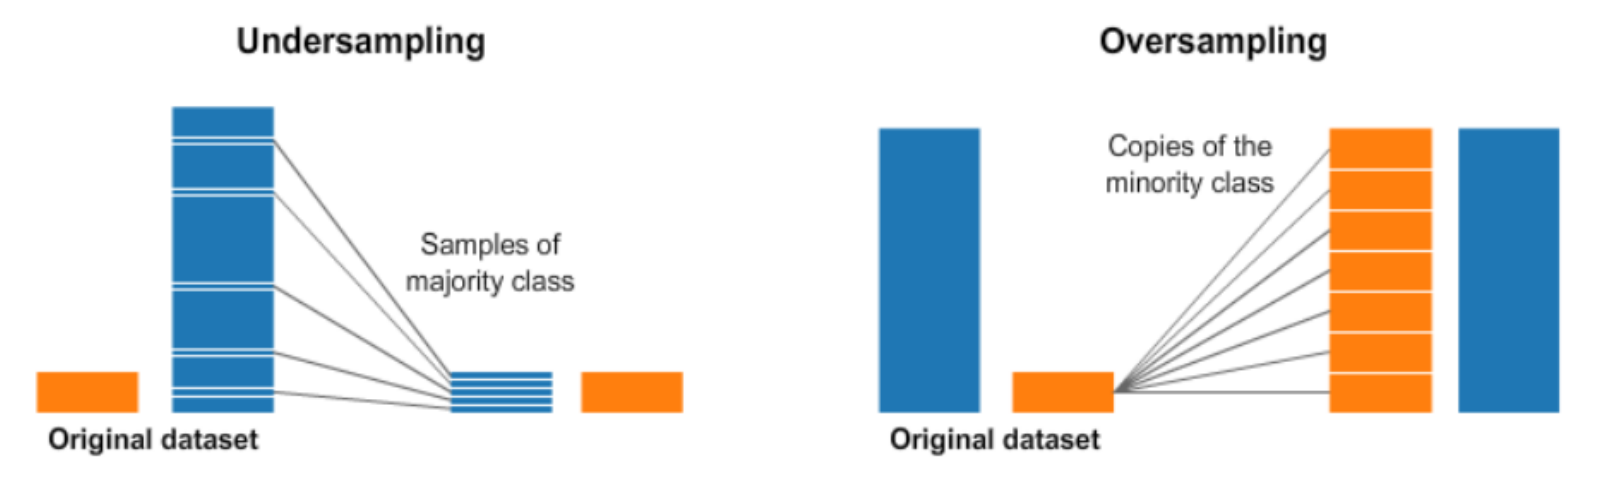


### 1. Smote upsampling

In [37]:
smote = SMOTE(k_neighbors = 4)
X_train_smote_sc, y_train_smote_sc = smote.fit_resample(Xtrain_Sc, y_train)

smote2 = SMOTE(k_neighbors = 4)
X_train_smote, y_train_smote = smote2.fit_resample(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
y_train_smote_count = y_train_smote.value_counts()
y_train_smote_count.plot(kind='pie', autopct='%.2f')
#y_train_smote_count.set_title("Smote Sampled train data")


In [ ]:
y_train_smote.value_counts()

# Machine Learning - Building models


__I will use three models:__
- Model 1 - Artificial Neuro Networks
- Model 2 - Logistic Regression
- Model 3 - Gaussian NB

__Each model will be runned with and without scaling three diffrent times. This will give a result of total 6 combination beacause im using samplingsmethods bellow.__ 
- Smote x 2 (with & without scaling)

__I will divide the result in every model into 6 cathegories: 1a, 1b, 2a, 2b, 3a, 3b.__ 
- Smote --> 1a (with scaling), 1b (without scaling)

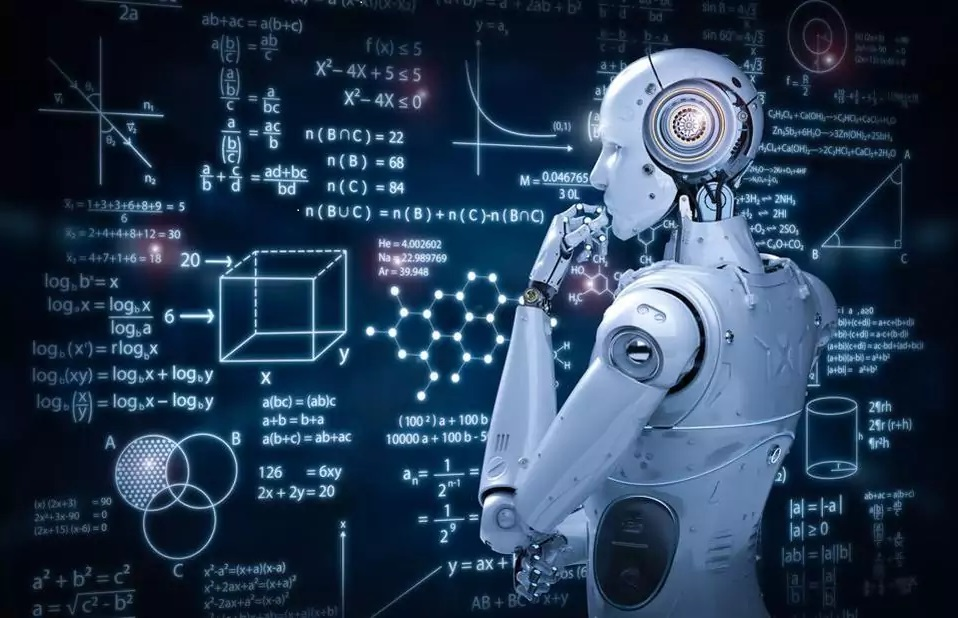


### Understanding the classification_report

__Precision/ Speciticity– What percent of your predictions were correct?__
- Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

__Recall/ Sensitivity – What percent of the positive cases did you catch?__ 
- Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.



__F1 score – What percent of positive predictions were correct?__
- The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. F1 Score is more accurate when you handle imbalanced datasets like this one. 

- __Formula:__ $F1 Score = 2*(Recall * Precision) / (Recall + Precision)$


__Accuracy__  - Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right.

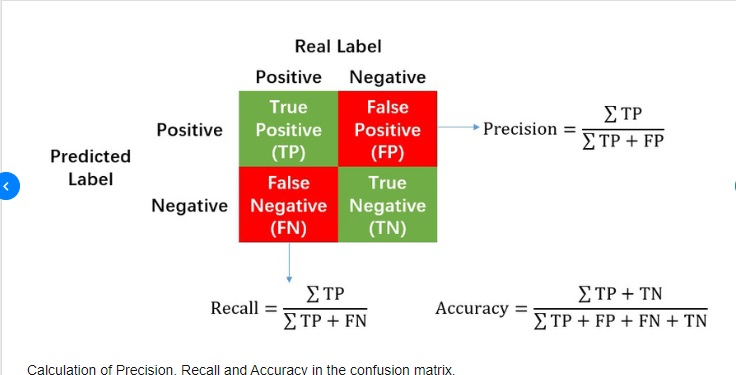



https://muthu.co/understanding-the-classification-report-in-sklearn/#:~:text=A%20Classification%20report%20is%20used,classification%20report%20as%20shown%20below.
https://www.youtube.com/watch?v=8d3JbbSj-I8&ab_channel=Scarlett%27sLog

# <span style='background :yellow' > Model 1 - Artificial Neuro Networks  </span>

### Creating an ANN function

In [ ]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

### 1a) Ann with Smote sampling

In [ ]:
ANN(X_train_smote_sc, y_train_smote_sc, X_test, y_test, 'binary_crossentropy', -1)

### 1b) Ann using Smote sampling __[without Scaling]__

In [ ]:
ANN(X_train_smote, y_train_smote, X_test, y_test, 'binary_crossentropy', -1)

# <span style='background :yellow' > Model 2 - Logistic Regression  </span>

###  2a) Logistic Regression  using Smote sampling __[with Scaling]__

In [ ]:
classifier  = LogisticRegression(random_state = 0, max_iter=500)

classifier.fit(X_train_smote_sc, y_train_smote_sc)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("")
print("Accuracy Score: ",  accuracy_score(y_test, y_pred) )
print("")
print(classification_report(y_test, y_pred))

###  2b) Logistic Regression using Smote sampling __[without Scaling]__

In [ ]:
classifier  = LogisticRegression(random_state = 0, max_iter=500)

classifier.fit(X_train_smote, y_train_smote)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("")
print("Accuracy Score: ",  accuracy_score(y_test, y_pred) )
print("")
print(classification_report(y_test, y_pred))

# <span style='background :yellow' > Model 3 - GaussianNB  </span>

###  3a) Gaussian NB using Smote sampling __[with Scaling]__

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train_smote_sc, y_train_smote_sc)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("")
print("Accuracy Score: ",  accuracy_score(y_test, y_pred) )
print("")
print(classification_report(y_test, y_pred))

###  3b) Gaussian NB using Smote sampling __[without Scaling]__

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train_smote, y_train_smote)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("")
print("Accuracy Score: ",  accuracy_score(y_test, y_pred) )
print("")
print(classification_report(y_test, y_pred))

# Conclusion:


This project did't not go ass well as I aspected. Most of the models show high accuracy score besides 2a-model Logistic regression with scaling method. Why? 

Well thats a good question... I'm not sure why LG scaling model fail when applying scaling. The whole model failed, not only accuracy. I used a MinMaxScaling method on the whole dataset. My scaling method is not correct when you are applying it on a dataset which are skewed, it's better to use standardscaler instead of normalisations scaler like I did. Reason why I used a normalisation scaler on this task is because i needed it for the ANN model. I used StandardScaler also but I delete it because my result was no better my current result. I used the StandardScaler on just three columns: Tenure, MonthlyCharges, TotalCharges. 


- The model with the highest Churn precision where: 3b, with only 0.13.

- The model with the highest Churn Recal where: 3b*, with a recall score of 0.61 

- The model with the highest Churn F1 score where  2b & 3b, with a score of 0.22 


Our six models show all low F1 score which means that all of the models fail. I tried many things to get a better classification report but didn't get a F1 - score higher than 0.31. Here is some things I tried:

- Changing order on scaling, sampling and splitting.
- Changing hyperparameters i the statistical models
- I tried diffrent sampling methods, TomekLinks, SmoteTomek and Smote
- I tried diffrent scaling methods 



Further readings: 

Analyze models performance and how to get better measure performance: 
https://cloud.ibm.com/docs/watson-knowledge-studio?topic=watson-knowledge-studio-evaluate-ml


